# Detecting facemasks in images with Faster R-CNN in Pytorch.

An important concept to understand for this project is **Transfer Learning**. 
>  Transfer learning is a machine learning method where we reuse a pre-trained model as the starting point for a model on a new task. To put it simply—a model trained on one task is repurposed on a second, related task as an optimization that allows rapid progress when modeling the second task.
### What is Faster R-CNN?
Faster R-CNN is a deep convolutional network used for object detection, that appears to the user as a single, end-to-end, unified network. The network can accurately and quickly predict the locations of different objects.

The region-based CNN (R-CNN), which is the first trial towards building an object detection model that extracts features using a pre-trained CNN. Next, Fast R-CNN is quickly reviewed, which is faster than the R-CNN but unfortunately neglects how the region proposals are generated. This is later solved by the Faster R-CNN, which builds a region-proposal network that can generate region proposals that are fed to the detection model (Fast R-CNN) to inspect for objects. 

<img src="j.png" alt="Alternative text" />

### Importing all the necessary libraries

In [1]:
import urllib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import os 
from PIL import Image
import random
import xml.etree.ElementTree as ET
import time
import requests

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


> Since I executed this project in Google Colab, this bit ensured I could access the needed files from my drive, in this case, the image data. 

### The data has been taken from Kaggle, and will be cited below. This dataset contains 853 images belonging to the 3 classes, as well as their bounding boxes in the PASCAL VOC format. The classes are:
* With mask;
* Without mask;
* Mask worn incorrectly.

>Citing the data: @misc{make ml,
title={Mask Dataset},
url={https://makeml.app/datasets/mask},
journal={Make ML}
}

In [3]:
# path of images directory
dir_path = '/content/gdrive/MyDrive/img data/images'
# path of xml files directory
xml_path = '/content/gdrive/MyDrive/img data/annotations'
# List of Image file names 
file_list = os.listdir(dir_path)
# Total Image files in the dataset:
print('There are total {} images.'.format(len(file_list)))

There are total 853 images.


In [4]:
# Helper function for reading the data (label and bounding boxes) from the annonations (xml files) 
def read_annot(file_name, xml_dir):
    # file_name: image file name
    # xml_dir: directory of xml file
    # bbox : list of bounding boxes
    # labels: list of labels
    
    bbox = []
    labels = []
    
    annot_path = os.path.join(xml_dir, file_name[:-3]+'xml')
    tree = ET.parse(annot_path)
    root = tree.getroot()
    for boxes in root.iter('object'):
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        label = boxes.find('name').text
        bbox.append([xmin,ymin,xmax,ymax])
        if label == 'with_mask':
            label_idx = 2
        else:
            label_idx = 1
        labels.append(label_idx)
        
    return bbox, labels

# help function for drawing the bounding boxes on the image
def draw_boxes(img, boxes,labels, thickness=1):

    # img: array of img (h, w ,c)
    # boxes: list of boxes (int)
    # labels: list of labels (int)
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for box,label in zip(boxes,labels):
        box = [int(x) for x in box]
        if label == 2:
            color = (0,225,0) # green
        elif label == 1:
            color = (0,0,225) # red
        cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]),color,thickness)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

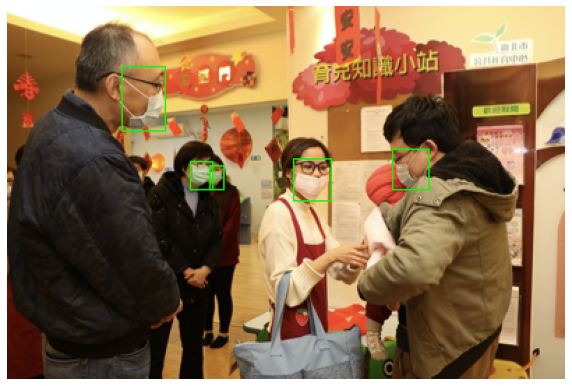

In [5]:
# To check what we've done, we randomly select an image
image_name = file_list[random.randint(0,len(file_list))] 

# Get the bbox and label
bbox, labels  = read_annot(image_name, xml_path)

#draw bounding boxes on the image
img = draw_boxes(plt.imread(os.path.join(dir_path,image_name)), bbox,labels)
    
# display the image
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.axis('off')
ax.imshow(img)

In [6]:
# Now we write our class
class image_dataset(Dataset):
    def __init__(self, image_list, image_dir, xml_dir):
        self.image_list = image_list
        self.image_dir = image_dir
        self.xml_dir = xml_dir
       
    def __getitem__(self, idx):
        # load img
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = transforms.ToTensor()(img)

        #build the target dict
        bbox, labels = read_annot(img_name, self.xml_dir)
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.zeros((len(bbox),), dtype=torch.int64)
        
        target = {}
        
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowed'] = iscrowd
        return img , target
                    
    def __len__(self):
        return len(self.image_list)

In [7]:
mask_dataset = image_dataset(file_list, dir_path, xml_path)
def collate_fn(batch):
    return tuple(zip(*batch))

mask_loader = DataLoader(mask_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
num_classes = 3 # background, without_mask, with_mask

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [11]:
# Setting the optimizer and no. of epochs
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,momentum=0.9, weight_decay=0.0005)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1) #will come back to this
num_epochs=30

In [12]:
# Main function to train the model
loss_list = []
for epoch in range(num_epochs):
    print('Starting training....{}/{}'.format(epoch+1, num_epochs))
    loss_sub_list = []
    start = time.time()
    for images, targets in mask_loader:
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        
        model.train()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_sub_list.append(loss_value)
        
        # updating optimizer and learning rate
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        #lr_scheduler.step() !
    end = time.time()
        
    #printing the epoch loss
    epoch_loss = np.mean(loss_sub_list)
    loss_list.append(epoch_loss)
    print('Epoch loss: {:.3f} , time used: ({:.1f}s)'.format(epoch_loss, end-start))

Starting training....1/30
Epoch loss: 0.401 , time used: (633.6s)
Starting training....2/30
Epoch loss: 0.288 , time used: (266.2s)
Starting training....3/30
Epoch loss: 0.249 , time used: (267.7s)
Starting training....4/30
Epoch loss: 0.210 , time used: (268.4s)
Starting training....5/30
Epoch loss: 0.194 , time used: (267.7s)
Starting training....6/30
Epoch loss: 0.177 , time used: (267.3s)
Starting training....7/30
Epoch loss: 0.163 , time used: (268.1s)
Starting training....8/30
Epoch loss: 0.154 , time used: (266.7s)
Starting training....9/30
Epoch loss: 0.144 , time used: (265.3s)
Starting training....10/30
Epoch loss: 0.134 , time used: (267.0s)
Starting training....11/30
Epoch loss: 0.123 , time used: (268.9s)
Starting training....12/30
Epoch loss: 0.123 , time used: (270.4s)
Starting training....13/30
Epoch loss: 0.117 , time used: (265.6s)
Starting training....14/30
Epoch loss: 0.114 , time used: (271.2s)
Starting training....15/30
Epoch loss: 0.111 , time used: (269.4s)
Star

In [14]:
torch.save(model.state_dict(),'/content/gdrive/MyDrive/Colab Notebooks/mymodel.pth')
# load it later to reuse it with trained weights.

In [16]:
# helper function for testing prediction on a single img
def single_img_predict(img, nm_thrs = 0.3, score_thrs=0.8):
    test_img = transforms.ToTensor()(img)
    model.eval()
    
    with torch.no_grad():
        predictions = model(test_img.unsqueeze(0).to(device))
        
    test_img = test_img.permute(1,2,0).numpy()
    
    # non-max supression
    keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(),predictions[0]['scores'].cpu(),nm_thrs)
    
    # Only display the bounding boxes which higher than the threshold
    score_filter = predictions[0]['scores'].cpu().numpy()[keep_boxes] > score_thrs
    
    # get the filtered result
    test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
    test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]
    
    return test_img, test_boxes, test_labels

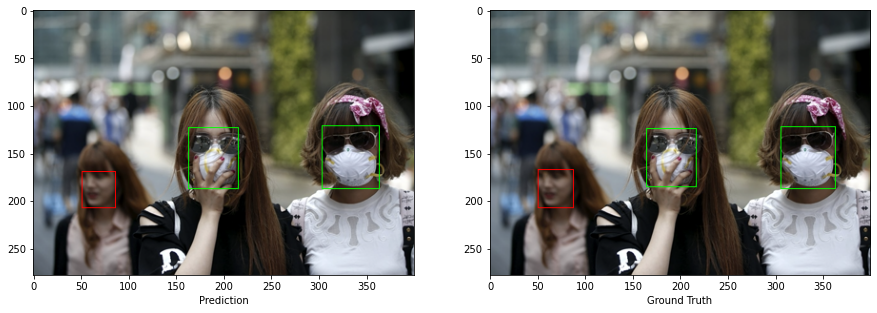

In [19]:
idx = 200
test_img = Image.open(os.path.join(dir_path,file_list[idx])).convert('RGB')

# Prediction
test_img, test_boxes, test_labels = single_img_predict(test_img)
test_output = draw_boxes(test_img, test_boxes,test_labels)

# Draw the bounding box of ground truth
bbox, labels  = read_annot(file_list[idx], xml_path)
# draw bounding boxes on the image
gt_output = draw_boxes(test_img, bbox,labels)

# Displaying result
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
ax1.imshow(test_output)
ax1.set_xlabel('Prediction')
ax2.imshow(gt_output)
ax2.set_xlabel('Ground Truth')
plt.show()

### We can try to see on other images from the internet to test the prediction

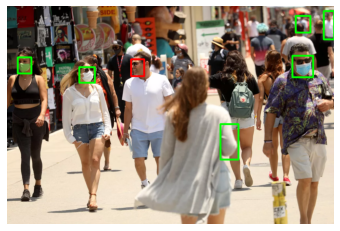

In [24]:
url = 'https://ca-times.brightspotcdn.com/dims4/default/b240c50/2147483647/strip/true/crop/6720x4480+0+0/resize/1200x800!/format/webp/quality/80/?url=https%3A%2F%2Fcalifornia-times-brightspot.s3.amazonaws.com%2F32%2F86%2F196191384a1c958a27503ed2008c%2Fla-photos-1staff-569403-me-0705-county-sees-alarming-rise-in-coronavirus-gem-005.jpg'
test_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')

test_img, test_boxes, test_labels = single_img_predict(test_img)

# adjusting the border thickness
test_output = draw_boxes(test_img, test_boxes,test_labels, thickness=5)
plt.axis('off')
plt.imshow(test_output)

> We can see that the model is doing decent predictions. Although it is still possible to make it more accurate, this much will have to do for now in this project. Thank you!